In [1]:
import keras_cv
import tensorflow as tf
from keras_cv import visualization
from tensorflow import keras
import train_ez as ez
import os
import cv2
from tqdm.auto import tqdm
import numpy as np

# Constants
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0
IMAGE_RESIZE = (640, 640)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Using TensorFlow backend
Num GPUs Available:  0


Since the dataset I will be using has images with white backgrounds, lets make sure the images are properly preprocessed so they have various backgrounds to exclude overfitting.

In [2]:
input_directory = 'unprocessed_images'
output_directory = 'data/palm'
background_directory = 'backgrounds'

background_images = [os.path.join(background_directory, f) for f in os.listdir(background_directory) if f.endswith(('.jpg', '.jpeg', '.png'))]

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Process each image in the input directory
for file_name in tqdm(os.listdir(input_directory)):
    if file_name.endswith(('.jpg', '.jpeg', '.png')):
        # Read the image
        image_path = os.path.join(input_directory, file_name)
        image = cv2.imread(image_path)
        if image is None:
                print(f"Failed to load image: {image_path}")
                continue
        # Replace the background
        new_image = ez.replace_white_background(image, background_images)
        if new_image is None:
                print(f"Failed to process image: {image_path}")
                continue
        # Save the new image
        output_path = os.path.join(output_directory, file_name)
        cv2.imwrite(output_path, new_image)

Alright now that we have workable data, lets arrange it into datasets that are properly formatted. To do so, we need to first make the initial dataset tensor. This portion is pretty self-explanatory.

In [3]:
class_ids = ['palm']

class_mapping = dict(zip(range(len(class_ids)), class_ids))

path_images = "./data/palm/"
path_annot = "./data/bboxes/"

images, bboxes, classes = ez.load_data_from_dir(path_images, path_annot, class_mapping)
image_paths = tf.ragged.constant(images)
bboxes = tf.ragged.constant(bboxes)
classes = tf.ragged.constant(classes)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bboxes))

num_val = int(len(data) * SPLIT_RATIO)
val_data = data.take(num_val)
train_data = data.skip(num_val)

Great, now that we have both a training dataset and a validation dataset, we can focus on making this model. First thing we do is resize the images to the correct size since we will be using a backbone model to build off of. YOLOv8 requires 640 * 640 px image inputs. Now is also a great time to add augmentation to our model so it can recognize the object in a wide variety of noise, angles, and sizes.

In [4]:

# Augmenter to apply to training dataset
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="vertical", bounding_box_format="xyxy"),
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.1, y_factor=0.1, bounding_box_format="xyxy"
        ),
        keras_cv.layers.Resizing(
            640, 640, bounding_box_format="xyxy", pad_to_aspect_ratio=True
        ),
        keras_cv.layers.RandomContrast(factor=0.4, value_range=(0,255)),
        keras_cv.layers.RandomBrightness(factor=0.4),
    ]
)

train_ds = train_data.map(ez.load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)


val_ds = val_data.map(ez.load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

Lets check to make sure these what we expect them to be.

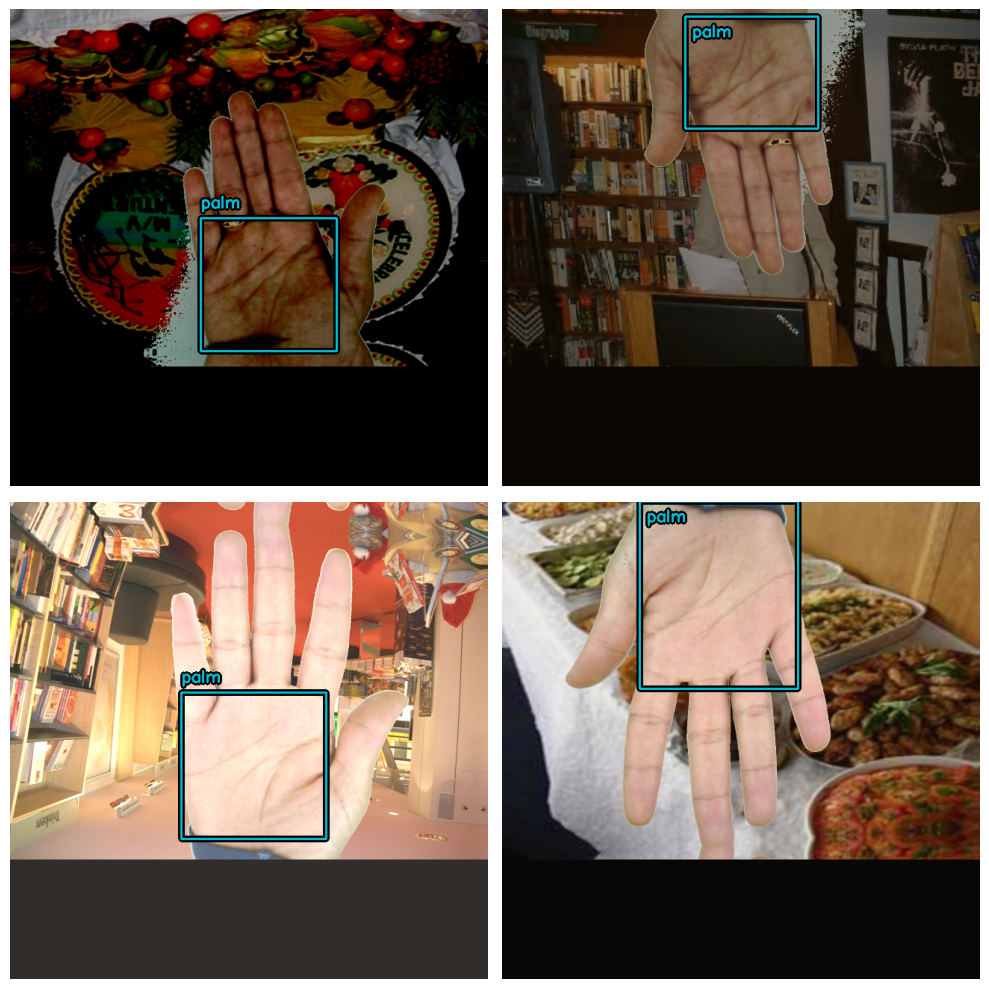

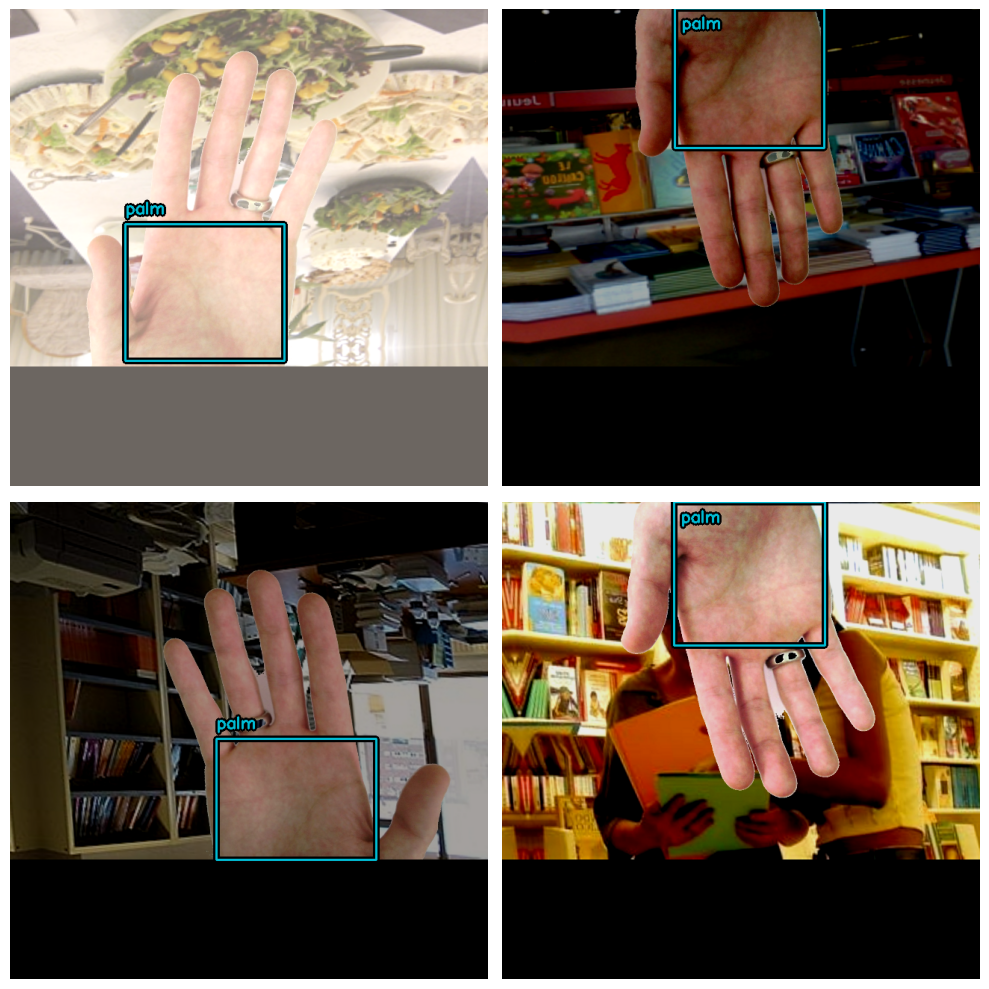

In [5]:
ez.visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

ez.visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

Looks good. Let's unpack our data for use in our model building.

In [6]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

We will use yolo_v8 small backbone with coco weights for an easy start. 

In [7]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco",
    load_weights=True
)

Next we use very standard KerasCV code to compile our initial model.

In [8]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=3,
)

yolo.summary()

optimizer = tf.keras.optimizers.SGD(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)
    
        metrics = self.metrics.result(force=True)
        logs.update(metrics)
    
        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            model_save_path = self.save_path + "_epoch_{}".format(epoch)
            weight_save_path = model_save_path + "_weights.h5"
            architecture_save_path = model_save_path + "_architecture.json"
    
            self.model.save_weights(weight_save_path)
    
            with open(architecture_save_path, 'w') as json_file:
                json_file.write(self.model.to_json())
    
            self.model.save(model_save_path)
            self.model.save(self.save_path)
    
            return logs

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs_yolov8small")


Model: "yolov8_detector"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 model (Functional)          {'P3': (None, None, None,    5089760   ['input_2[0][0]']             
                             128),                                                                
                              'P4': (None, None, None,                                            
                             256),                                                                
                              'P5': (None, None, None,                                            
                             512)}                                                  

Let the training begin!

In [9]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=[
        EvaluateCOCOMetricsCallback(val_ds, "model_SGD.keras"),
        tensorboard_callback
    ],
)

Epoch 1/5
649/649 [==============================] - ETA: 0s - loss: 155.6384 - box_loss: 2.7162 - class_loss: 152.9221INFO:tensorflow:Assets written to: model_SGD.keras_epoch_0\assets


INFO:tensorflow:Assets written to: model_SGD.keras_epoch_0\assets


649/649 [==============================] - 2239s 3s/step - loss: 155.6384 - box_loss: 2.7162 - class_loss: 152.9221 - val_loss: 19.4379 - val_box_loss: 2.2679 - val_class_loss: 17.1700 - MaP: 0.0022 - MaP@[IoU=50]: 0.0081 - MaP@[IoU=75]: 2.6443e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0022 - Recall@[max_detections=1]: 0.0082 - Recall@[max_detections=10]: 0.0767 - Recall@[max_detections=100]: 0.1375 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.1375
Epoch 2/5
649/649 [==============================] - ETA: 0s - loss: 11.0350 - box_loss: 1.9532 - class_loss: 9.0818INFO:tensorflow:Assets written to: model_SGD.keras_epoch_1\assets


INFO:tensorflow:Assets written to: model_SGD.keras_epoch_1\assets


649/649 [==============================] - 2236s 3s/step - loss: 11.0350 - box_loss: 1.9532 - class_loss: 9.0818 - val_loss: 6.4642 - val_box_loss: 1.9219 - val_class_loss: 4.5424 - MaP: 0.3868 - MaP@[IoU=50]: 0.9003 - MaP@[IoU=75]: 0.1738 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.3868 - Recall@[max_detections=1]: 0.4796 - Recall@[max_detections=10]: 0.5046 - Recall@[max_detections=100]: 0.5046 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.5046
Epoch 3/5
649/649 [==============================] - ETA: 0s - loss: 4.5967 - box_loss: 1.4700 - class_loss: 3.1266INFO:tensorflow:Assets written to: model_SGD.keras_epoch_2\assets


INFO:tensorflow:Assets written to: model_SGD.keras_epoch_2\assets


649/649 [==============================] - 2276s 3s/step - loss: 4.5967 - box_loss: 1.4700 - class_loss: 3.1266 - val_loss: 4.0328 - val_box_loss: 1.7789 - val_class_loss: 2.2539 - MaP: 0.4550 - MaP@[IoU=50]: 0.9965 - MaP@[IoU=75]: 0.2539 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.4550 - Recall@[max_detections=1]: 0.5364 - Recall@[max_detections=10]: 0.5413 - Recall@[max_detections=100]: 0.5413 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.5413
Epoch 4/5
649/649 [==============================] - 2219s 3s/step - loss: 3.1286 - box_loss: 1.3159 - class_loss: 1.8127 - val_loss: 3.4520 - val_box_loss: 1.8245 - val_class_loss: 1.6275 - MaP: 0.4390 - MaP@[IoU=50]: 0.9882 - MaP@[IoU=75]: 0.2082 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.4390 - Recall@[max_detections=1]: 0.5194 - Recall@[max_detections=10]: 0.5221 - Recall@[max_detections=100]: 0.5221 - Recall@[a

And as for our results...

1/1 [==============================] - 1s 1s/step


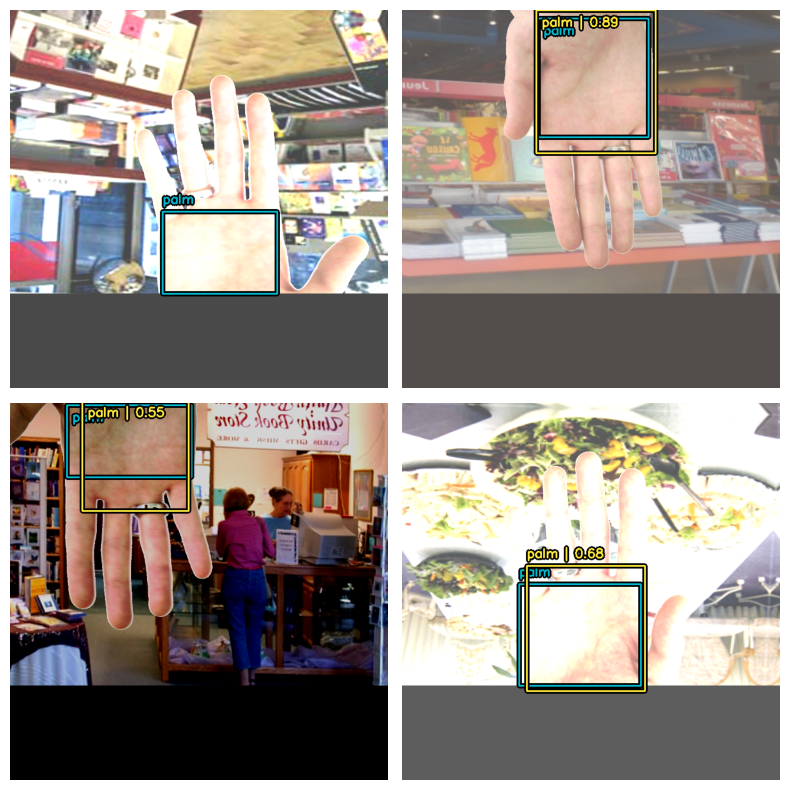

In [10]:
ez.visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy") 

Here I am going to build the model from the save file to make sure it works. I have issues using keras' load model on just the .kerar file so for now this wil have to be the method I use.

In [32]:
model_fake = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=3,
)

optimizer = tf.keras.optimizers.SGD(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

model_fake.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

model_fake.load_weights("./model_SGD.keras_epoch_2_weights.h5")

1/1 [==============================] - 1s 1s/step


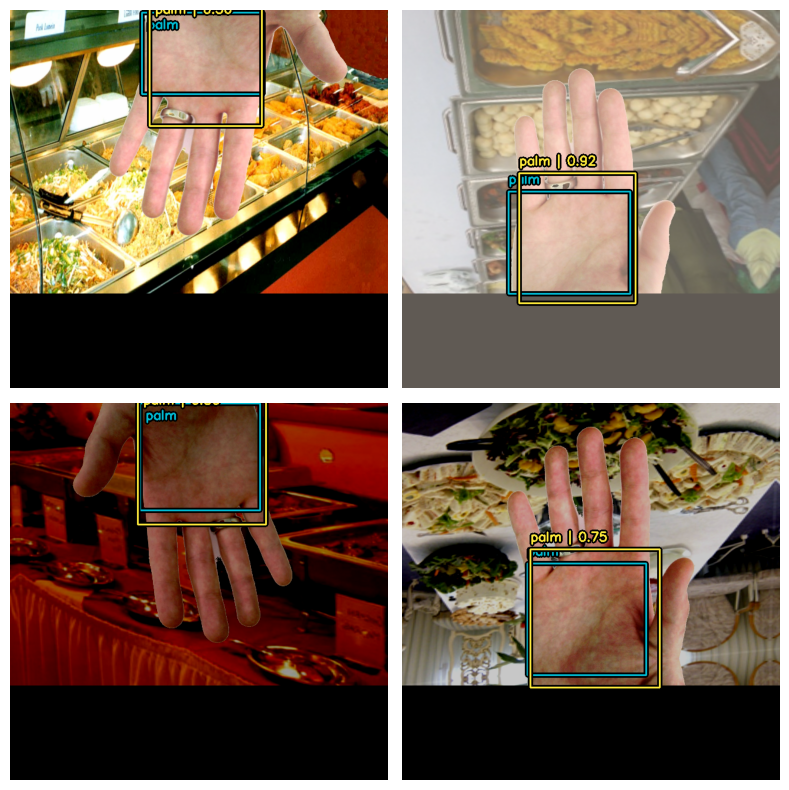

In [35]:
ez.visualize_detections(model_fake, dataset=val_ds, bounding_box_format="xyxy", class_mapping=class_mapping) 

Let us try on a custom image for a final verification.

1/1 [==============================] - 0s 369ms/step


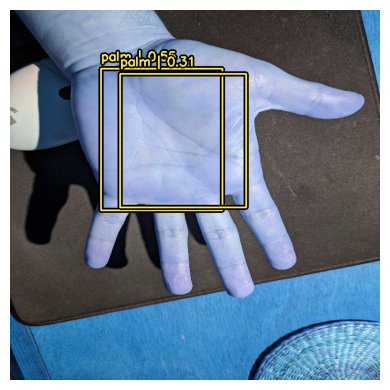

In [49]:
from keras_cv import visualization, bounding_box


image_path = 'model_test_images/test5.jpg'
image = cv2.imread(image_path)
resized_image = cv2.resize(image, (640, 640))
image = np.expand_dims(resized_image, axis=0).astype(np.float32)

y_pred = model_fake.predict(image)
y_pred = bounding_box.to_ragged(y_pred)
visualization.plot_bounding_box_gallery(
        image,
        value_range=(0, 255),
        bounding_box_format='xyxy',
        y_pred=y_pred,
        scale=4,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.7,
        # TODO: Remove hard code
        class_mapping={0: 'palm'},
    )
